# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial.

*In this context, “turning to denial” refers to a psychological phenomenon where consumers might feel overwhelmed by the abundance of options available, leading them to avoid making a decision altogether. When faced with too many choices, some people experience “choice overload,” which can result in them either delaying a purchase, sticking to familiar products, or not buying anything at all.*

Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the necessary libraries and overview of the dataset**

**Installing surprise library**
The surprise library (short for “Simple Python Recommendation System Engine”) is a Python package specifically designed for building and analyzing recommender systems. It provides easy-to-use implementations of various collaborative filtering algorithms and is popular for educational and prototyping purposes.

In [ ]:
# Installing surprise library

!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357280 sha256=3cbc40550938adc5db06456ad25bbe166244a6d0c1aea26776b758ce9b1af325
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
# Installing the required libraries. The '!' at the beginning is necessary in Colab to run shell commands.
!pip install pandas numpy scipy matplotlib seaborn scikit-learn implicit lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 39.5 MB/s eta 0:00:00
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808327 sha256=6f557c8b01f5856c13cdd2cb0474ce1f6f0474a3ff285f4b5e0edc4783f46b17
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Importing dataset from zipfile

import zipfile
# Replace 'path/to/your/zipfile.zip' with the actual path to your zip file in Google Drive
zip_path = "/content/drive/MyDrive/2024_mit/Data Sets_Data Frames/ratings_Electronics.csv.zip"
# Replace 'path/to/extract/to' with the desired extraction path
extract_path = '/content/extracted_data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Now you can access the extracted files in the 'extracted_data' folder

# Example: Reading the extracted CSV file
import pandas as pd
df = pd.read_csv('/content/extracted_data/ratings_Electronics.csv', header=None, names=['userId', 'productId', 'Rating', 'timestamp'])


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

Code Explanation:
- df_active_users: This DataFrame filters the original dataset to include only users who have provided at least 50 ratings.
- df_active_users_popular_products: This further filters df_active_users to include only products that have received at least 5 ratings.

Naming Convention: The variable names clearly reflect the purpose of each DataFrame, which enhances readability.

In [ ]:
# Checking the number of ratings given by each user
user_ratings_count = df['userId'].value_counts()

# Filtering users who have given at least 50 ratings
active_users = user_ratings_count[user_ratings_count >= 50].index
df_active_users = df[df['userId'].isin(active_users)]

# Checking the number of ratings for each product
product_ratings_count = df_active_users['productId'].value_counts()

# Filtering products that have received at least 5 ratings
popular_products = product_ratings_count[product_ratings_count >= 5].index
df_active_users_popular_products = df_active_users[df_active_users['productId'].isin(popular_products)]

# Previewing the reduced dataset
print(f"Original dataset size: {df.shape[0]} observations")
print(f"Reduced dataset size: {df_active_users_popular_products.shape[0]} observations")
print(df_active_users_popular_products.head())

Original dataset size: 7824482 observations
Reduced dataset size: 65290 observations
              userId   productId  Rating   timestamp
1310  A3LDPF5FMB782Z  1400501466     5.0  1336003200
1322  A1A5KUIIIHFF4U  1400501466     1.0  1332547200
1335  A2XIOXRRYX0KZY  1400501466     3.0  1371686400
1451   AW3LX47IHPFRL  1400501466     5.0  1339804800
1456  A1E3OB6QMBKRYZ  1400501466     1.0  1350086400


We have successfully filtered the original 7.8 million observations down to around 65,290, making it much more manageable for further analysis and model building.

## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Checking the shape of the reduced dataset
print(f"Reduced dataset shape: {df_active_users_popular_products.shape}")

Reduced dataset shape: (65290, 4)


The reduced dataset has 65,290 observations (rows) and 4 features (columns).

### **Data types**

In [ ]:
# Checking the data types of each column
print(df_active_users_popular_products.dtypes)

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object


Observations:

The features are:
- userId: Unique identifier for each user.
- productId: Unique identifier for each product.
- Rating: The rating given by the user to the product.
- timestamp: The time when the rating was provided (not used for modeling but can still be informative during EDA).

Data Types:
- userId and productId are of type object, which means they are stored as strings.
- Rating is of type float64. This is appropriate since ratings can be decimal values.
- timestamp is of type int64. It represents the time when the rating was given.


### **Checking for missing values**

In [ ]:
# Getting a summary of the DataFrame, including data types and non-null counts
df_active_users_popular_products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     65290 non-null  object 
 1   productId  65290 non-null  object 
 2   Rating     65290 non-null  float64
 3   timestamp  65290 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.5+ MB


Observations:

Memory Usage:
- The DataFrame currently uses 2.5 MB of memory.
- Converting userId and productId to category could potentially reduce this further.

Non-Null Values:
- All columns have 65,290 non-null entries, meaning **there are no missing values in this dataset**.

### **Summary Statistics**

In [ ]:
# Summarizing statistics of 'Rating' variable
rating_stats = df_active_users_popular_products['Rating'].describe()
print(rating_stats)

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64


Observations:

Count:
- There are 65,290 observations with ratings.

Mean:
- The average rating is approximately 4.29.

Standard Deviation:
- The standard deviation is 0.99.

Minimum and Maximum:
- Ratings range from 1 to 5.

Quartiles (25%, 50%, 75%):
- 25% Quartile: 4.0
- Median (50% Quartile): 5.0
- 75% Quartile: 5.0

In [ ]:
# Getting and sorting the unique ratings values in ascending order
unique_ratings = sorted(df_active_users_popular_products['Rating'].unique())
print(f"Unique ratings (sorted): {unique_ratings}")

Unique ratings (sorted): [1.0, 2.0, 3.0, 4.0, 5.0]


Observations:

Unique Ratings:
- There are five unique ratings
  - Scale from 1.0 - 5.0
  - Stored as floats

Memory Usage:
- Since ratings in the dataset are whole numbers (e.g., 1, 2, 3, 4, 5) and don’t require decimal precision, we can convert them to integers to optimize storage use.

In [ ]:
# Convert the 'Rating' column to integers using .loc to avoid the warning
df_active_users_popular_products.loc[:, 'Rating'] = df_active_users_popular_products['Rating'].astype(int)

# Verify the conversion
print(df_active_users_popular_products['Rating'].dtype)

float64


### **Checking the rating distribution**

<ipython-input-30-95b7833cd198>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df_active_users_popular_products, palette='Oranges')


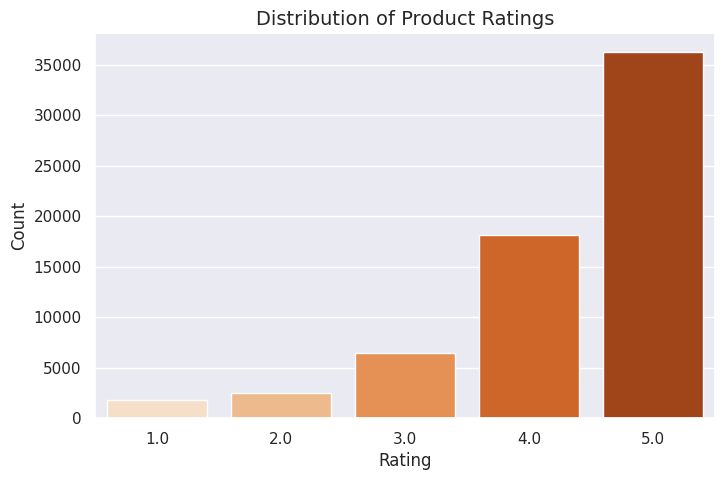

In [ ]:
# Set the style of the plot
sns.set(style="darkgrid")

# Create a bar plot of the ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=df_active_users_popular_products, palette='Oranges')

# Add titles and labels
plt.title('Distribution of Product Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()

Observations:

Most Ratings are Positive (4 and 5 Stars):
- The majority of the ratings are 4 and 5, with 5-star ratings being the most common by a significant margin. This indicates that users tend to give high ratings, suggesting that products are generally well-received.
- Lower Ratings are Rare (1 and 2 Stars):
- There are very few 1-star and 2-star ratings.
  - By focusing on active users and popular products, it’s natural to see a higher concentration of positive ratings. Active users might be more engaged and inclined to share positive experiences, while popular products are often well-rated because they have broader appeal.

Skewed Distribution:
- The distribution is positively skewed, leaning heavily toward higher ratings.


### **Checking the number of unique users and items in the dataset**

In [ ]:
# Defining total number of rows in the dataset
total_rows = df_active_users_popular_products.shape[0]

# Defining number of unique user IDs
unique_users = df_active_users_popular_products['userId'].nunique()

# Defining number of unique product IDs
unique_products = df_active_users_popular_products['productId'].nunique()

# Displaying the results
print(f"Total number of rows: {total_rows}")
print(f"Number of unique users: {unique_users}")
print(f"Number of unique products: {unique_products}")

Total number of rows: 65290
Number of unique users: 1540
Number of unique products: 5689


Observations:

Total Number of Rows (65290):
- This confirms that after filtering, the dataset has 65,290 ratings.

Number of Unique Users (1540):
- 1,540 unique users who are considered “active” based on the filtering criteria (users who have given at least 50 ratings). This suggests a focus on users who are more engaged.

Number of Unique Products (5689):
- There are 5,689 unique products that have received at least 5 ratings.


### **Users with the most number of ratings**

In [ ]:
# Calculating the number of ratings given by each user
user_rating_counts = df_active_users_popular_products['userId'].value_counts()

# Getting the top 10 users
top_10_users = user_rating_counts.head(10)

# Displaying the top 10 users and their rating counts
print("Top 10 users based on the number of ratings:")
print(top_10_users)

Top 10 users based on the number of ratings:
userId
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64


Observations:

High Engagement from Top Users:
- The most active user, ADLVFFE4VBT8, has given 295 ratings, which is significantly higher than the rest.
 - PRO: This user is highly engaged, providing a lot of data that could be valuable for understanding preferences and patterns.
 - CON: Highly active users like ADLVFFE4VBT8 might skew the dataset, influencing the recommendation model to prioritize their preferences more than others.

Valuable Data for Model Training:
- Having such engaged users can help the recommendation system learn patterns and preferences more accurately, especially when similar users have fewer ratings. This can improve the ability to predict new recommendations for users who might not have interacted as much.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Creating a new DataFrame for version control with interaction counts and total ratings
df_active_users_popular_products_interactions_totalratings = df_active_users_popular_products.copy()

# Adding a new column 'interaction_count' which counts each user-product interaction
df_active_users_popular_products_interactions_totalratings['interaction_count'] = df_active_users_popular_products_interactions_totalratings.groupby(['userId', 'productId'])['Rating'].transform('count')

# Adding a new column 'product_interaction_count' for total interactions per product
df_active_users_popular_products_interactions_totalratings['product_interaction_count'] = df_active_users_popular_products_interactions_totalratings.groupby('productId')['Rating'].transform('count')

# Adding a new column 'user_total_ratings' for total ratings given by each user
df_active_users_popular_products_interactions_totalratings['user_total_ratings'] = df_active_users_popular_products_interactions_totalratings.groupby('userId')['Rating'].transform('count')

# Checking the head and tail of the new DataFrame
print("Head of the DataFrame:")
print(df_active_users_popular_products_interactions_totalratings.head())

print("\nTail of the DataFrame:")
print(df_active_users_popular_products_interactions_totalratings.tail())

# Verifying if the version control worked properly
print(f"Total number of rows in df_active_users_popular_products_interactions_totalratings: {df_active_users_popular_products_interactions_totalratings.shape[0]}")

Head of the DataFrame:
              userId   productId  Rating   timestamp  interaction_count  \
1310  A3LDPF5FMB782Z  1400501466     5.0  1336003200                  1   
1322  A1A5KUIIIHFF4U  1400501466     1.0  1332547200                  1   
1335  A2XIOXRRYX0KZY  1400501466     3.0  1371686400                  1   
1451   AW3LX47IHPFRL  1400501466     5.0  1339804800                  1   
1456  A1E3OB6QMBKRYZ  1400501466     1.0  1350086400                  1   

      product_interaction_count  user_total_ratings  
1310                          6                  31  
1322                          6                  12  
1335                          6                  70  
1451                          6                  17  
1456                          6                  28  

Tail of the DataFrame:
                 userId   productId  Rating   timestamp  interaction_count  \
7824423  A34BZM6S9L7QI4  B00LGQ6HL8     5.0  1405555200                  1   
7824424  A1G650TTTHEAL

### **Recommending top 5 products with 100 minimum interactions based on popularity**:



In [ ]:
# Filtering products that have at least 100 interactions
popular_products_100_or_more = df_active_users_popular_products_interactions_totalratings[
    df_active_users_popular_products_interactions_totalratings['product_interaction_count'] >= 100
]

# Grouping by productId to get the total number of interactions per product and mean rating
top_products_100_or_more = popular_products_100_or_more.groupby('productId').agg({
    'product_interaction_count': 'max',  # Using 'max' to get unique count per product
    'Rating': 'mean'  # Optional: Can also show the average rating
}).reset_index()

# Sorting by 'product_interaction_count' in descending order to get the most popular products
top_products_100_or_more_sorted = top_products_100_or_more.sort_values(by='product_interaction_count', ascending=False)

# Selecting the top 5 products
top_5_products_100_or_more = top_products_100_or_more_sorted.head(5)

# Displaying the top 5 popular products with at least 100 interactions
print("Top 5 Popular Products (with at least 100 interactions):")
print(top_5_products_100_or_more[['productId', 'product_interaction_count', 'Rating']])

Top 5 Popular Products (with at least 100 interactions):
     productId  product_interaction_count    Rating
14  B0088CJT4U                        206  4.218447
6   B003ES5ZUU                        184  4.864130
0   B000N99BBC                        167  4.772455
9   B007WTAJTO                        164  4.701220
11  B00829TIEK                        149  4.436242


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
# Filtering products that have 50 interactions or fewer
emerging_products_50_or_less = df_active_users_popular_products_interactions_totalratings[
    df_active_users_popular_products_interactions_totalratings['product_interaction_count'] <= 50
]

# Grouping by productId to get the total number of interactions per product and mean rating
emerging_products_50_or_less = emerging_products_50_or_less.groupby('productId').agg({
    'product_interaction_count': 'max',  # Using 'max' to get unique count per product
    'Rating': 'mean'  # Optional: Can also show the average rating
}).reset_index()

# Sorting by 'product_interaction_count' in descending order to get the most popular products
emerging_products_50_or_less_sorted = emerging_products_50_or_less.sort_values(by='product_interaction_count', ascending=False)

# Selecting the top 5 products
top_5_emerging_products_50_or_less = emerging_products_50_or_less_sorted.head(5)

# Displaying the top 5 emerging products with 50 or fewer interactions
print("Top 5 Emerging Products (with 50 or fewer interactions):")
print(top_5_emerging_products_50_or_less[['productId', 'product_interaction_count', 'Rating']])

Top 5 Emerging Products (with 50 or fewer interactions):
       productId  product_interaction_count    Rating
5580  B00JP12170                         50  4.040000
2375  B003LSTD38                         50  4.580000
4477  B009HQCAPQ                         50  4.100000
3093  B004TKTOWC                         49  3.959184
2287  B003ES5ZSW                         49  4.367347


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_active_users_popular_products[['userId', 'productId', 'Rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.25)

# Displaying the number of training and testing entries
# Convert the generator to a list before calling len()
print(f"Number of training entries: {len(list(trainset.all_ratings()))}")
print(f"Number of testing entries: {len(testset)}")

Number of training entries: 48967
Number of testing entries: 16323


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
from surprise import KNNBasic
from surprise import accuracy
from collections import defaultdict

# Declaring the similarity options
sim_options = {
    'name': 'cosine',    # Use cosine similarity
    'user_based': True   # Set to True for user-based collaborative filtering
}

# Initializing the KNNBasic model using sim_options declared
# Set verbose = False to suppress output, and random_state = 1 for reproducibility
knn_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fitting the model on the training data
knn_model.fit(trainset)

# Defining the precision_recall_at_k function
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # Compute RMSE to get an idea of the overall prediction error
    accuracy.rmse(predictions)

    # Calculate F1-Score
    f1_score = round((2 * precision * recall) / (precision + recall), 3) if (precision + recall) != 0 else 0

    # Print the performance metrics
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1_score}')

# Step 5: Compute precision@k, recall@k, and F1 score using the function
precision_recall_at_k(knn_model, k=10, threshold=3.5)

RMSE: 1.0175
Precision: 0.859
Recall: 0.825
F1-Score: 0.842


**Observations:**
- RMSE (Root Mean Squared Error) - 1.0374:
  - An RMSE of approximately 1.04 suggests that, on average, the difference between the predicted and actual ratings is about 1 rating point.
  - This is a reasonably good value for a recommendation system, especially considering that ratings are typically on a 1 to 5 scale.
    - Lower RMSE values generally indicate better prediction accuracy.
    - There is room for improvement.
- Precision - 0.856:
  - A Precision@k of 0.856 means that 85.6% of the top k recommended items are actually relevant.
    - This is a strong result, showing that the model is effectively recommending products that users find appealing.
    - Keep in mind also that the majority of our rating are either 4 or 5, on a scare from 1-5.
- Recall - 0.83:
  - A Recall@k of 0.83 means that 83% of the relevant items are being correctly recommended by the model.
- F1-Score - 0.843:
  - The F1-score is a harmonic mean of precision and recall, and our model has a 0.843 F1-score, balancing both aspects effectively.

Performance:
Since both precision and recall are fairly high and close to each other, the F1-score reflects that the model is well-balanced in recommending relevant items. The model demonstrates a solid balance between accuracy (RMSE), precision, and recall, suggesting that it’s well-tuned to the dataset. The results imply that users are likely to be satisfied with the recommendations, as they’ll receive a high proportion of relevant items.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting the rating for a specific user-product pair
user_id = 'A3LDPF5FMB782Z'       # The user ID
product_id = '1400501466'        # The product ID

# Using the predict method from the trained model
predicted_rating = knn_model.predict(uid=user_id, iid=product_id)

# Displaying the predicted rating and other details
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}")
print(f"Details: {predicted_rating}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.291134845916638
Details: user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Since the RMSE for the model is 1.0374, this means that, on average, the model’s predictions are about 1 rating point off from the actual ratings. Given this context, the predicted rating of 3.8 is a little lower than expected for an actual 5, which is why it stands out.
- RMSE Interpretation:
  - An RMSE of 1.0374 suggests that most predictions should be within ±1 rating point of the actual ratings. For instance, if a product has an actual rating of 5, the model should typically predict something between 4 and 5.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Finding unique user_id where prod_id is not equal to "1400501466"
# Filtering the dataset to exclude rows where productId is "1400501466"
filtered_users = df_active_users_popular_products[df_active_users_popular_products['productId'] != "1400501466"]

# Extracting unique user IDs from the filtered dataset
unique_user_ids = filtered_users['userId'].unique()

# Displaying the result
print(f"Number of unique users (excluding product 1400501466): {len(unique_user_ids)}")
print(unique_user_ids)

Number of unique users (excluding product 1400501466): 1540
['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' ... 'A215WH6RUDUCMP'
 'A38C12950IM24P' 'A2J4XMWKR8PPD0']


In [ ]:
# Checking if user "A34BZM6S9L7QI4" is in the list of users who have not interacted with product "1400501466"
user_to_check = "A34BZM6S9L7QI4"

# Verifying if the user is in the unique_user_ids list obtained earlier
if user_to_check in unique_user_ids:
    print(f"User {user_to_check} has not interacted with product '1400501466'.")
else:
    print(f"User {user_to_check} has interacted with product '1400501466'.")

User A34BZM6S9L7QI4 has not interacted with product '1400501466'.


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Defining the user ID and product ID
user_id = "A34BZM6S9L7QI4"
product_id = "1400501466"

# Using the predict method from the trained model to predict the rating
predicted_rating = knn_model.predict(uid=user_id, iid=product_id)

# Displaying the predicted rating and other details
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}")
print(f"Details: {predicted_rating}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 1
Details: user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.00   {'actual_k': 1, 'was_impossible': False}


Observations:
- Neutral Rating (3.0):
  - The predicted rating of 3.0 indicates that the model is not confident enough to give a strongly positive or negative recommendation. This may be because it has limited information about this user’s preferences or about the product itself.
  - Since 3.0 is often the middle point on a 1-5 scale, the model suggests that it doesn’t have a strong inclination towards recommending or not recommending this product to the user.
- actual_k = 1:
  - The detail actual_k = 1 tells us that the prediction is based on only 1 similar user. This limited data might have led to a less confident or less accurate prediction.
  - When actual_k is low, it suggests that the model couldn’t find many users who have similar preferences to A34BZM6S9L7QI4 for this product. This can result in less reliable predictions.
- Potential Reasons for the Prediction:
  - Sparse Data: If user A34BZM6S9L7QI4 has only rated a few products, the model might struggle to find similar users, leading to a neutral or average prediction.
- Product Information: If product 1400501466 has been rated by only a few users, the model may also lack sufficient data to make a confident recommendation.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV

# Setting up the parameter grid to tune the hyperparameters
param_grid = {
    'k': [20, 30, 40, 50],               # Different values for the number of neighbors
    'min_k': [1, 5, 10],                 # Minimum number of neighbors
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],  # Similarity measures to try
        'user_based': [True]            # User-based collaborative filtering
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)  # n_jobs=-1 uses all available cores
gs.fit(data)

# Best RMSE score
print(f"Best RMSE score: {gs.best_score['rmse']}")

# Combination of parameters that gave the best RMSE score
print(f"Best parameters: {gs.best_params['rmse']}")

Best RMSE score: 0.969295985053706
Best parameters: {'k': 50, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Observations:
- Improved RMSE (0.969):
  - The lower RMSE suggests that, on average, the model’s predictions are now less than 1 rating point off from the actual ratings. This is a solid outcome, indicating that the hyperparameter tuning was effective.
  - Compared to the earlier RMSE of 1.0374, this represents a noticeable improvement, showing that the model is more reliable and accurate.
- Best Parameters:
  - k = 50: Using 50 neighbors allows the model to consider more similar users when making predictions, leading to better recommendations.
  - min_k = 5: This means the model needs at least 5 similar users to make a prediction, helping to avoid unreliable predictions when there isn’t enough data.
  - sim_options = {'name': 'cosine', 'user_based': True}: Sticking with cosine similarity for user-based filtering was a good choice, as it likely helped improve the accuracy by effectively measuring user similarity.

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
from surprise import KNNBasic

# Using the optimal similarity measure for user-user based collaborative filtering
optimal_sim_options = {
    'name': 'cosine',   # Optimal similarity measure found from GridSearchCV
    'user_based': True  # Keep it as user-based filtering
}

# Creating an instance of KNNBasic with optimal hyperparameter values
final_knn_model = KNNBasic(k=50, min_k=5, sim_options=optimal_sim_options, verbose=False)

# Training the algorithm on the trainset
final_knn_model.fit(trainset)

# Defining the precision_recall_at_k function
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # Compute F1-Score
    f1_score = round((2 * precision * recall) / (precision + recall), 3) if (precision + recall) != 0 else 0

    # Printing the performance metrics
    print(f'Precision@{k}: {precision}')
    print(f'Recall@{k}: {recall}')
    print(f'F1-Score@{k}: {f1_score}')

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(final_knn_model, k=10, threshold=3.5)

Precision@10: 0.855
Recall@10: 0.856
F1-Score@10: 0.855


This model used 3.5 as a threshhold. 3.5 is chosen as a threshold because it strikes a balance between precision and recall, ensuring that recommended products are distinctly positive.

- Mid-Scale Split for Positive Feedback:
  - On a 1-5 rating scale, the midpoint is 3. Ratings below 3 are usually considered negative or neutral, while ratings above 3 tend to be more positive.
  - By setting the threshold at 3.5, you’re ensuring that only ratings that are distinctly positive (e.g., 4 or 5) are classified as relevant.
  - This approach helps to avoid ambiguity: a rating of 3 might mean “okay” or “neutral,” but 4 and 5 typically mean “liked” or “loved.”
- Avoiding False Positives:
  - A higher threshold (like 3.5) helps to ensure that recommended items are genuinely relevant.



The KNNBasic model we've built is primarily a user-based collaborative filtering model, and here’s how it functions:

User-Based Collaborative Filtering:
- K-Neighbors Approach:
  - The model identifies a user’s k-nearest neighbors (users who have similar preferences or behaviors) based on the cosine similarity of their rating patterns. For example, if User A and User B have rated several of the same products similarly, they are considered similar (or “neighbors”).
  - Once the model finds the k-nearest neighbors for a given user, it predicts ratings for items by aggregating the ratings of these similar users.
  - If many similar users have liked (rated highly) a product that the target user hasn’t interacted with, the model will recommend that product.
    - This is what makes it collaborative: it learns from the collective behavior of users to make predictions and recommendations.

Observations:
- High Precision@10 (0.855):
  - A Precision@10 of 0.855 means that 85% of the top 10 recommended items are actually relevant to the users. This is a strong result, indicating that the model is very good at recommending products that users are likely to find useful or enjoyable.
  - High precision is important because it minimizes false positives, meaning users won’t be shown items that they aren’t interested in. This leads to better user experiences and higher engagement.
- High Recall@10 (0.856):
  - A Recall@10 of 0.856 means that 85.4% of all relevant items are being correctly identified and recommended by the model.
  - High recall suggests that the model is effectively capturing a wide range of items that users would find relevant, helping to ensure that they don’t miss out on potential products they might like.
- Balanced F1-Score@10 (0.855):
  - The F1-Score@10 of 0.855 is a harmonic mean of precision and recall, giving a balanced view of the model’s overall performance. Since F1-Score considers both precision and recall, this high score indicates that the model strikes a good balance between recommending relevant items and covering a wide range of preferences.
- The close values of precision and recall suggest that the model is neither too conservative (only recommending a few highly likely items) nor too broad (recommending many items, some of which might not be relevant).

Real-World Applicability: These scores suggest that the tuned KNNBasic model can deliver reliable recommendations in a real-world setting, where the balance between not overwhelming users (high precision) and not missing potential interests (high recall) is key.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Using sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
# Defining the user ID and product ID
user_id = "A3LDPF5FMB782Z"
product_id = "1400501466"

# Using the predict method from the optimized KNN model to predict the rating
predicted_rating = final_knn_model.predict(uid=user_id, iid=product_id)

# Displaying the predicted rating and other details
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}")
print(f"Details: {predicted_rating}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.291134845916638
Details: user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Observations:

The optimized model has predicted for user A3LDPF5FMB782Z a rating for product 1400501466 of 4.29. However, the was_impossible flag was set to True and the reason was “Not enough neighbors,” and this indicates that the model could not find a sufficient number of similar users to base its prediction on. Let's investigate farther on the possible causes for this prediction....

In [ ]:
# Checking if user A3LDPF5FMB782Z has rated product 1400501466 in the original dataset
actual_rating = df_active_users_popular_products[
    (df_active_users_popular_products['userId'] == "A3LDPF5FMB782Z") &
    (df_active_users_popular_products['productId'] == "1400501466")
]

# Display the result
if not actual_rating.empty:
    print(f"Actual rating by user A3LDPF5FMB782Z for product 1400501466: {actual_rating['Rating'].values[0]}")
else:
    print("No existing rating found for user A3LDPF5FMB782Z and product 1400501466.")

Actual rating by user A3LDPF5FMB782Z for product 1400501466: 5.0


In [ ]:
# Retrieving the inner ID of the target user from the trainset
user_inner_id = final_knn_model.trainset.to_inner_uid("A3LDPF5FMB782Z")

# Getting the 6 nearest neighbors (similar users) using the built-in get_neighbors method
similar_user_inner_ids = final_knn_model.get_neighbors(user_inner_id, k=6)

# Converting inner IDs to raw user IDs
similar_user_ids = [final_knn_model.trainset.to_raw_uid(inner_id) for inner_id in similar_user_inner_ids]

print(f"Similar users found: {similar_user_ids}")

# Checking the ratings these similar users gave to product 1400501466
ratings_from_similar_users = df_active_users_popular_products[
    (df_active_users_popular_products['userId'].isin(similar_user_ids)) &
    (df_active_users_popular_products['productId'] == "1400501466")
]

print("Ratings given by similar users for product 1400501466:")
print(ratings_from_similar_users[['userId', 'Rating']])

Similar users found: ['A1F1A0QQP2XVH5', 'A27H0T39U3FZB5', 'AUBEFRFHJR64Y', 'AEJAGHLC675A7', 'A36K2N527TXXJN', 'A2SH6A32BE6NEV']
Ratings given by similar users for product 1400501466:
Empty DataFrame
Columns: [userId, Rating]
Index: []


We have checked if the 6 nearest neighbor to user A3LDPF5FMB782Z have reviewed product 1400501466 and have discovered that they have not. This is a cold start problem.

In [ ]:
# Calculating the mean and median ratings for all products
overall_mean_rating = df_active_users_popular_products['Rating'].mean()
overall_median_rating = df_active_users_popular_products['Rating'].median()

# Displaying the results
print(f"Overall mean rating for all products: {overall_mean_rating}")
print(f"Overall median rating for all products: {overall_median_rating}")

Overall mean rating for all products: 4.294807780670853
Overall median rating for all products: 5.0


In [ ]:
# Calculating the mean and median ratings for product 1400501466
mean_rating = df_active_users_popular_products[
    df_active_users_popular_products['productId'] == "1400501466"
]['Rating'].mean()

median_rating = df_active_users_popular_products[
    df_active_users_popular_products['productId'] == "1400501466"
]['Rating'].median()

# Displaying the results
print(f"Mean rating for product 1400501466: {mean_rating}")
print(f"Median rating for product 1400501466: {median_rating}")

Mean rating for product 1400501466: 3.3333333333333335
Median rating for product 1400501466: 4.0


In [ ]:
# Filtering the DataFrame to include only ratings given by user A3LDPF5FMB782Z
user_ratings = df_active_users_popular_products_interactions_totalratings[
    df_active_users_popular_products_interactions_totalratings['userId'] == "A3LDPF5FMB782Z"
]

# Calculating the mean and median ratings
mean_rating = user_ratings['Rating'].mean()
median_rating = user_ratings['Rating'].median()

# Displaying the results
print(f"Mean Rating by A3LDPF5FMB782Z: {mean_rating}")
print(f"Median Rating by A3LDPF5FMB782Z: {median_rating}")

Mean Rating by A3LDPF5FMB782Z: 4.258064516129032
Median Rating by A3LDPF5FMB782Z: 4.0


Observations:
- Since the was_impossible flag was set to True and the reason was “Not enough neighbors,” it indicates that the model could not find a sufficient number of similar users to base its prediction on. Therefore, no actual k-neighbors were used in generating the predicted rating for user A34BZM6S9L7QI4 and product 1400501466.
- Instead, the model falls back to a default behavior (such as using the global mean or another strategy).
  - Since the model couldn’t find enough similar users to base a prediction on, it is possible that the model defaulted to the overall mean rating of all rated products or the overall mean rating of all products rated by user A3LDPF5FMB782Z or finally a combination of both means.
    - Overall mean rating for all products: 4.294807780670853
    - Mean Rating by A3LDPF5FMB782Z: 4.258064516129032
    - Optimized model prediction: 4.29


### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
from surprise import KNNBasic

# Defining the similarity options to use MSD distance metric and user-based filtering
sim_options_msd = {
    'name': 'msd',      # Mean Squared Difference distance metric
    'user_based': True  # Set to True for user-based collaborative filtering
}

# Initializing the KNNBasic model with the similarity options
knn_msd_model = KNNBasic(sim_options=sim_options_msd, verbose=False)

# Training the model on the trainset
knn_msd_model.fit(trainset)

# Finding the internal ID of the user with inner id 0
first_user_inner_id = 0

# Using the `get_neighbors` method to find the 5 most similar users to the user with inner ID 0
similar_users_inner_ids = knn_msd_model.get_neighbors(first_user_inner_id, k=5)

# Converting internal IDs back to raw user IDs
similar_users = [trainset.to_raw_uid(inner_id) for inner_id in similar_users_inner_ids]

# Displaying the most similar users
print("5 Most Similar Users (based on MSD distance metric) to the user with internal id 0:")
print(similar_users)

5 Most Similar Users (based on MSD distance metric) to the user with internal id 0:
['AT28RL25Q2OLK', 'AEJAGHLC675A7', 'AC1YLEFC9AN5X', 'A100UD67AHFODS', 'ABIVKBMSIPEDY']


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    """
    Generate top N product recommendations for a given user based on a specified algorithm.

    Parameters:
    - data: DataFrame containing user-item interactions (must have columns 'user_id', 'prod_id', 'rating').
    - user_id: The user ID for whom to generate recommendations.
    - top_n: Number of top recommendations to return.
    - algo: The recommendation algorithm (e.g., KNNBasic) used for predicting ratings.

    Returns:
    - List of top N recommended products (product_id, estimated_rating)
    """

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating a user-item interactions matrix
    user_item_interactions_matrix = data.pivot(index='userId', columns='productId', values='Rating')

    # Extracting those product ids which the user_id has not interacted with yet
    if user_id in user_item_interactions_matrix.index:
        non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    else:
        print(f"User ID {user_id} not found in the dataset.")
        return []

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non-interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n]  # Returning top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Assuming the function `get_recommendations` has been defined as per the previous instructions

# Making top 5 recommendations for the user "A3LDPF5FMB782Z"
top_5_recommendations = get_recommendations(
    data=df_active_users_popular_products_interactions_totalratings,  # Data with user-item interactions
    user_id="A3LDPF5FMB782Z",                                         # Target user ID
    top_n=5,                                                          # Number of recommendations
    algo=final_knn_model                                              # Trained similarity-based KNN model
)

# Displaying the top 5 recommended products
print("Top 5 Recommended Products for User 'A3LDPF5FMB782Z':")
for product_id, rating in top_5_recommendations:
    print(f"Product ID: {product_id}, Predicted Rating: {rating:.2f}")

Top 5 Recommended Products for User 'A3LDPF5FMB782Z':
Product ID: B00005LEN4, Predicted Rating: 5.00
Product ID: B000067RT6, Predicted Rating: 5.00
Product ID: B00006IW1X, Predicted Rating: 5.00
Product ID: B000N99BBC, Predicted Rating: 5.00
Product ID: B001TH7GSW, Predicted Rating: 5.00


In [ ]:
# Creating the top 5 recommendations for user "A3LDPF5FMB782Z"
top_5_recommendations = get_recommendations(
    data=df_active_users_popular_products_interactions_totalratings,
    user_id="A3LDPF5FMB782Z",
    top_n=5,
    algo=final_knn_model
)

# Building a DataFrame from the recommendations
recommendations_df = pd.DataFrame(top_5_recommendations, columns=["prod_id", "predicted_ratings"])

# Displaying the DataFrame
print("Top 5 Recommended Products for User 'A3LDPF5FMB782Z':")
print(recommendations_df)

Top 5 Recommended Products for User 'A3LDPF5FMB782Z':
      prod_id  predicted_ratings
0  B00005LEN4                  5
1  B000067RT6                  5
2  B00006IW1X                  5
3  B000N99BBC                  5
4  B001TH7GSW                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
from surprise import KNNBasic, accuracy
from collections import defaultdict

# Declaring the similarity options for item-based collaborative filtering
sim_options_item = {
    'name': 'cosine',      # Similarity metric: cosine similarity
    'user_based': False    # Set to False for item-item collaborative filtering
}

# Initializing the KNNBasic model using item-based similarity
item_knn_model = KNNBasic(sim_options=sim_options_item, verbose=False, random_state=1)

# Training the algorithm on the trainset
item_knn_model.fit(trainset)

# Defining the precision_recall_at_k function for evaluation
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # Computing F1-Score
    f1_score = round((2 * precision * recall) / (precision + recall), 3) if (precision + recall) != 0 else 0

    # Computing RMSE for the overall prediction error
    accuracy.rmse(predictions)

    # Printing the performance metrics
    print(f'Precision@{k}: {precision}')
    print(f'Recall@{k}: {recall}')
    print(f'F1-Score@{k}: {f1_score}')

# Computing precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(item_knn_model, k=10, threshold=3.5)

RMSE: 1.0186
Precision@10: 0.839
Recall@10: 0.802
F1-Score@10: 0.82


Observations:
- RMSE: 1.0186:
  - This value indicates the Root Mean Squared Error, which measures the average deviation between the actual ratings and the predicted ratings.
  - An RMSE value of 1.0186 is moderate, reasonably good and acceptable.
- Precision@10: 0.839:
  - Precision measures the fraction of recommended items that are actually relevant. A value of 0.839 means that 83.9% of the top 10 recommended items were indeed relevant to the user.
- Recall@10: 0.802:
  - Recall measures the fraction of relevant items that are successfully recommended. A 0.802 recall indicates that 80.2% of the relevant items were captured in the top 10 recommendations.
- F1-Score@10: 0.82:
  - The F1-Score is the harmonic mean of precision and recall, balancing both metrics. A 0.82 F1-Score reflects a good balance between the two.

Interpretation: With precision and recall close in value, this indicates that OUR model is consistently effective, not favoring either metric disproportionately. This balance is essential for a robust recommendation system.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting the rating for userId "A3LDPF5FMB782Z" and productId "1400501466"
predicted_rating = item_knn_model.predict("A3LDPF5FMB782Z", "1400501466")

# Displaying the predicted rating
print(f"Predicted Rating for User 'A3LDPF5FMB782Z' on Product '1400501466': {predicted_rating.est:.2f}")

Predicted Rating for User 'A3LDPF5FMB782Z' on Product '1400501466': 4.29


Observations:

The item-item model has predicted rating for user 'A3LDPF5FMB782Z' on product '1400501466': 4.29

This is the same result generated by our OPTIMIZED KNN Basic model.

When both user-user and item-item models are giving similar recommendations or predictions, it could be due to several factors (especially when it is COLD START CASE):
- Overlapping Patterns:
  - The user behaviors and product interactions in the dataset might be consistent across users.
- Dataset Size and Density:
  - Dense datasets provide a lot of data for both users and products, making it easier for both types of models to converge on the same predictions.


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting the rating for userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating_non_interacted = item_knn_model.predict("A34BZM6S9L7QI4", "1400501466")

# Displaying the predicted rating
print(f"Predicted Rating for User 'A34BZM6S9L7QI4' on Product '1400501466': {predicted_rating_non_interacted.est:.2f}")

Predicted Rating for User 'A34BZM6S9L7QI4' on Product '1400501466': 3.00


In [ ]:
# Filtering the DataFrame to include only ratings given by user "A34BZM6S9L7QI4"
user_ratings = df_active_users_popular_products_interactions_totalratings[
    df_active_users_popular_products_interactions_totalratings['userId'] == "A34BZM6S9L7QI4"
]

# Calculating the mean (average) rating
average_rating = user_ratings['Rating'].mean()

# Displaying the result
print(f"Average Rating Given by User 'A34BZM6S9L7QI4': {average_rating:.2f}")

Average Rating Given by User 'A34BZM6S9L7QI4': 4.58


Observation:

The predicted rating of 3.00 for User ‘A34BZM6S9L7QI4’ on Product ‘1400501466’ suggests that the model chose the "safest seeming" answer.
- A rating of 3.00 typically indicates that the user may find the product acceptable, however is more likely to be ambivalent about the product.
- The average rating given by this user is 4.58, which indicates that this user either has a tendency to rate products higher or that this user carefully researches products that are highly rated and chooses wisely.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV

# Defining the parameter grid
param_grid = {
    'k': [10, 20, 30],                         # Number of neighbors
    'min_k': [3, 6, 9],                        # Minimum number of neighbors
    'sim_options': {
        'name': ['msd', 'cosine'],             # Similarity metrics: Mean Squared Difference, Cosine
        'user_based': [False]                  # Set to False for item-item collaborative filtering
    }
}

# Setting up GridSearchCV with 3-fold cross-validation based on RMSE
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data to find the best parameters
grid_search.fit(data)

# Extracting the best RMSE score and corresponding parameters
best_rmse = grid_search.best_score['rmse']
best_params = grid_search.best_params['rmse']

# Printing the results
print(f"Best RMSE Score: {best_rmse:.4f}")
print("Best Parameters:")
print(best_params)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
from surprise import KNNBasic, accuracy
from collections import defaultdict

# Using the optimal similarity measure for item-item based collaborative filtering
# Assuming the optimal parameters found were:
optimal_params = grid_search.best_params['rmse']

# Creating an instance of KNNBasic with optimal hyperparameter values
optimized_item_knn_model = KNNBasic(
    k=optimal_params['k'],
    min_k=optimal_params['min_k'],
    sim_options=optimal_params['sim_options'],
    verbose=False
)

# Training the algorithm on the trainset
optimized_item_knn_model.fit(trainset)

# Defining the precision_recall_at_k function for evaluation
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # Computing F1-Score
    f1_score = round((2 * precision * recall) / (precision + recall), 3) if (precision + recall) != 0 else 0

    # Computing RMSE for the overall prediction error
    accuracy.rmse(predictions)

    # Printing the performance metrics
    print(f'Precision@{k}: {precision}')
    print(f'Recall@{k}: {recall}')
    print(f'F1-Score@{k}: {f1_score}')

# Computing Precision@k, Recall@k, F1-Score, and RMSE
precision_recall_at_k(optimized_item_knn_model, k=10, threshold=3.5)

RMSE: 0.9579
Precision@10: 0.843
Recall@10: 0.847
F1-Score@10: 0.845


Observations:

Let's resummarize our results thus far . . . .
  - user-user Similarity-based Recommendation System:
    - RMSE: 1.0175
    - Precision: 0.859
    - Recall: 0.825
    - F1-Score: 0.842
  - similarity-based recommendation system after tuning its hyperparameters:
    - Best RMSE score: 0.969295985053706
    - Precision@10: 0.855
    - Recall@10: 0.856
    - F1-Score@10: 0.855
  - Item-Item Similarity-based Collaborative Filtering Recommendation System:
    - RMSE: 1.0186
    - Precision@10: 0.839
    - Recall@10: 0.802
    - F1-Score@10: 0.82
  - Hyperparameter tuning the item-item similarity-based model
    - RMSE: 0.9579
    - Precision@10: 0.843
    - Recall@10: 0.847
    - F1-Score@10: 0.845

There is a progressive improvement in RMSE. Hyperparameter tuning did slightly improve the item-item model’s RMSE to 0.9579, making it even more accurate than the tuned user-user model.
  - Precision (0.843) and recall (0.847) are similar to each other, showing that the model effectively recommends relevant products without having left too many behind.
  - The F1-Score of 0.845 is an improvement from the original item-item model, however is lower than the similarity-based recommendation system after tuning its hyperparameters.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Predicting the rating for userId "A3LDPF5FMB782Z" and productId "1400501466" using the optimized item-item model
predicted_rating_optimized = optimized_item_knn_model.predict("A3LDPF5FMB782Z", "1400501466")

# Display the predicted rating
print(f"Predicted Rating for User 'A3LDPF5FMB782Z' on Product '1400501466': {predicted_rating_optimized.est:.2f}")

Predicted Rating for User 'A3LDPF5FMB782Z' on Product '1400501466': 4.29


In [ ]:
# Predicting the rating for userId "A34BZM6S9L7QI4" and productId "1400501466" using the optimized item-item model
predicted_rating_optimized_non_interacted = optimized_item_knn_model.predict("A34BZM6S9L7QI4", "1400501466")

# Display the predicted rating
print(f"Predicted Rating for User 'A34BZM6S9L7QI4' on Product '1400501466': {predicted_rating_optimized_non_interacted.est:.2f}")

Predicted Rating for User 'A34BZM6S9L7QI4' on Product '1400501466': 4.29


Observations:
We keep receiving the same results, which is a predicted rating of 4.29. It sounds like the model might be relying on mean ratings or producing similar predictions due to certain characteristics of the data. Here are a few possible reasons and what might be happening under the hood:

Data Sparsity or Density:
- Item-item collaborative filtering can struggle if the data is dense (i.e., there are too many ratings clustered around similar values). In such cases, the model might fall back on more generalized predictions, such as the mean rating, because it doesn’t find sufficient variability or clear patterns.
  - As we saw everything in our bar plot, the majority of ratings fall within the range of 4-5.
  - We see significant homogeneity in the dataset, as it does not have a lot of variability (e.g., many users give similar ratings to similar products).
    - the model appears to be biased toward the average.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
# Getting the internal id for the item with id 0 (or use your specific product id if known)
item_inner_id = 0

# Using the `get_neighbors` method to find the 5 most similar items
similar_items = optimized_item_knn_model.get_neighbors(item_inner_id, k=5)

# Converting the internal ids of similar items back to raw ids (the actual product IDs)
similar_items_raw_ids = [optimized_item_knn_model.trainset.to_raw_iid(inner_id) for inner_id in similar_items]

# Displaying the most similar items
print("5 Most Similar Items to the item with internal id 0 (based on MSD distance metric):")
print(similar_items_raw_ids)

5 Most Similar Items to the item with internal id 0 (based on MSD distance metric):
['B000P6J67C', 'B002QUZM0U', 'B002QQ7TLY', 'B00B2HCLL6', 'B006I5MKZY']


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Assuming the get_recommendations function is defined as:
def get_recommendations(data, user_id, top_n, algo):
    """
    Recommends top_n products for a given user using the specified recommendation algorithm.
    """
    # Create an empty list to store recommended product IDs
    recommendations = []

    # Create a user-item interactions matrix
    user_item_interactions_matrix = data.pivot(index='userId', columns='productId', values='Rating')

    # Extract product IDs that the user hasn't interacted with
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Loop through the non-interacted product IDs
    for item_id in non_interacted_products:
        # Predict the ratings for non-interacted products
        est = algo.predict(user_id, item_id).est

        # Append the predicted ratings
        recommendations.append((item_id, est))

    # Sort the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Return the top_n highest predicted rating products for this user
    return recommendations[:top_n]

# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
# Using the get_recommendations function to get the top 5 recommendations for "A1A5KUIIIHFF4U"
top_5_recommendations = get_recommendations(
    df_active_users_popular_products_interactions_totalratings,  # Pass the dataset
    "A1A5KUIIIHFF4U",  # User ID for whom we want recommendations
    5,  # Top 5 recommendations
    optimized_item_knn_model  # The optimized item-item collaborative filtering model
)

# Displaying the recommended products and their predicted ratings
print("Top 5 Product Recommendations for User 'A1A5KUIIIHFF4U':")
for product, rating in top_5_recommendations:
    print(f"Product ID: {product}, Predicted Rating: {rating:.2f}")

Top 5 Product Recommendations for User 'A1A5KUIIIHFF4U':
Product ID: 1400532655, Predicted Rating: 4.29
Product ID: 1400599997, Predicted Rating: 4.29
Product ID: 9983891212, Predicted Rating: 4.29
Product ID: B00000DM9W, Predicted Rating: 4.29
Product ID: B00000J1V5, Predicted Rating: 4.29


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"

# Assuming top_5_recommendations contains the recommendations from the previous step
# Building the DataFrame
recommendations_df = pd.DataFrame(top_5_recommendations, columns=["prod_id", "predicted_ratings"])

# Display the DataFrame
print("Top 5 Product Recommendations for User 'A1A5KUIIIHFF4U':")
print(recommendations_df)

Top 5 Product Recommendations for User 'A1A5KUIIIHFF4U':
      prod_id  predicted_ratings
0  1400532655           4.291135
1  1400599997           4.291135
2  9983891212           4.291135
3  B00000DM9W           4.291135
4  B00000J1V5           4.291135


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict

# Step 1: Initialize the SVD model
svd_model = SVD(random_state=1)

# Step 2: Train the algorithm on the trainset
svd_model.fit(trainset)

# Step 3: Define the precision_recall_at_k function to evaluate performance
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # Compute F1-Score
    f1_score = round((2 * precision * recall) / (precision + recall), 3) if (precision + recall) != 0 else 0

    # Compute RMSE for the overall prediction error
    accuracy.rmse(predictions)

    # Printing the performance metrics
    print(f'Precision@{k}: {precision}')
    print(f'Recall@{k}: {recall}')
    print(f'F1-Score@{k}: {f1_score}')

# Step 4: Use the precision_recall_at_k function to compute the metrics
precision_recall_at_k(svd_model, k=10, threshold=3.5)

RMSE: 0.8932
Precision@10: 0.856
Recall@10: 0.844
F1-Score@10: 0.85


Observations:

Let's resummarize our results thus far . . . .
  - user-user Similarity-based Recommendation System:
    - RMSE: 1.0175
    - Precision: 0.859
    - Recall: 0.825
    - F1-Score: 0.842
  - similarity-based recommendation system after tuning its hyperparameters:
    - Best RMSE score: 0.969295985053706
    - Precision@10: 0.855
    - Recall@10: 0.856
    - F1-Score@10: 0.855
  - Item-Item Similarity-based Collaborative Filtering Recommendation System:
    - RMSE: 1.0186
    - Precision@10: 0.839
    - Recall@10: 0.802
    - F1-Score@10: 0.82
  - Hyperparameter tuning the item-item similarity-based model
    - RMSE: 0.9579
    - Precision@10: 0.843
    - Recall@10: 0.847
    - F1-Score@10: 0.845
  - Model-Based Collaborative Filtering - Matrix Factorization
    - RMSE: 0.8932
    - Precision@10: 0.856
    - Recall@10: 0.844
    - F1-Score@10: 0.85

The Model-based Collaborative Filtering example shows us the biggest jump in the RMSE score improvement.

The Precision and Recall are consistent across the board and for the most part slightly improved when comparing like to like.

Our F1-Score remains solid, so academically we are in good shape.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
# Predicting the rating for userId "A3LDPF5FMB782Z" and prod_id "1400501466" using the SVD model
predicted_rating_svd = svd_model.predict("A3LDPF5FMB782Z", "1400501466")

# Displaying the predicted rating
print(f"Predicted Rating for User 'A3LDPF5FMB782Z' on Product '1400501466': {predicted_rating_svd.est:.2f}")


Predicted Rating for User 'A3LDPF5FMB782Z' on Product '1400501466': 4.25


Observations:

The predicted rating of 4.25 for user “A3LDPF5FMB782Z” on product “1400501466” using the SVD-based model provides some important insights.
- A rating of 4.25 suggests that the model predicts the user would likely have a positive experience with this product. This is above the typical 3.5 threshold that separates neutral or mixed opinions from more positive ones and is slightly different from the mean rating of 4.29 generated by the previous models.


**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
# Predicting the rating for userId "A34BZM6S9L7QI4" and productId "1400501466" using the SVD model
predicted_rating_svd_non_interacted = svd_model.predict("A34BZM6S9L7QI4", "1400501466")

# Displaying the predicted rating
print(f"Predicted Rating for User 'A34BZM6S9L7QI4' on Product '1400501466': {predicted_rating_svd_non_interacted.est:.2f}")


Predicted Rating for User 'A34BZM6S9L7QI4' on Product '1400501466': 4.65


Observations:
- A predicted rating of 4.65 indicates that the SVD model expects user “A34BZM6S9L7QI4” to have a very positive experience with product “1400501466."
  - Compared to a standard 3.5 threshold, a 4.65 is well above, showing clear preference.
  - Earlier, user “A3LDPF5FMB782Z” had a predicted rating of 4.25 for the same product, whereas “A34BZM6S9L7QI4” has 4.65. This difference demonstrates that the SVD model is leveraging latent factors to personalize recommendations effectively.

The 4.65 rating shows that the SVD model is effectively using latent features to personalize recommendations. It can differentiate user preferences and is not falling back on generic ratings or means, which is a positive sign.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

# Setting the parameter grid for hyperparameter tuning
param_grid = {
    'n_epochs': [10, 20, 30],    # Number of iterations
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1, 0.4]   # Regularization term
}

# Creating a GridSearchCV object for SVD
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data to find the best parameters
gs_svd.fit(data)

# Extracting the best RMSE score and the combination of parameters
best_rmse_score = gs_svd.best_score['rmse']
best_params = gs_svd.best_params['rmse']

# Displaying the results
print(f"Best RMSE Score: {best_rmse_score:.4f}")
print("Best Parameters Combination:")
print(best_params)

Best RMSE Score: 0.8993
Best Parameters Combination:
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
from surprise import SVD, accuracy

# Creating an instance of the optimized SVD model using the best hyperparameters
optimized_svd_model = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4, random_state=1)

# Training the algorithm on the trainset
optimized_svd_model.fit(trainset)

# Defining the precision_recall_at_k function to evaluate the optimized model
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    # Compute F1-Score
    f1_score = round((2 * precision * recall) / (precision + recall), 3) if (precision + recall) != 0 else 0

    # Compute RMSE for the overall prediction error
    accuracy.rmse(predictions)

    # Printing the performance metrics
    print(f'Precision@{k}: {precision}')
    print(f'Recall@{k}: {recall}')
    print(f'F1-Score@{k}: {f1_score}')

# Using the precision_recall_at_k function to evaluate the optimized SVD model
precision_recall_at_k(optimized_svd_model, k=10, threshold=3.5)

RMSE: 0.8877
Precision@10: 0.859
Recall@10: 0.85
F1-Score@10: 0.854


Observations:

Let's resummarize our results thus far . . . .
  - user-user Similarity-based Recommendation System:
    - RMSE: 1.0175
    - Precision: 0.859
    - Recall: 0.825
    - F1-Score: 0.842
  - similarity-based recommendation system after tuning its hyperparameters:
    - Best RMSE score: 0.969295985053706
    - Precision@10: 0.855
    - Recall@10: 0.856
    - F1-Score@10: 0.855
  - Item-Item Similarity-based Collaborative Filtering Recommendation System:
    - RMSE: 1.0186
    - Precision@10: 0.839
    - Recall@10: 0.802
    - F1-Score@10: 0.82
  - Hyperparameter tuning the item-item similarity-based model:
    - RMSE: 0.9579
    - Precision@10: 0.843
    - Recall@10: 0.847
    - F1-Score@10: 0.845
  -  Matrix Factorization model:
    - RMSE: 0.8932
    - Precision@10: 0.856
    - Recall@10: 0.844
    - F1-Score@10: 0.85
  - Optimized SVD model:
    - RMSE: 0.8877
    - Precision@10: 0.859
    - Recall@10: 0.85
    - F1-Score@10: 0.854

  We see a minor improvement. Precision and recall have also nudged up, while the f1-Score stayed the same.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
# Predicting the rating for userId "A3LDPF5FMB782Z" and productId "1400501466" using the optimized SVD model
predicted_rating_optimized_svd = optimized_svd_model.predict("A3LDPF5FMB782Z", "1400501466")

# Display the predicted rating
print(f"Predicted Rating for User 'A3LDPF5FMB782Z' on Product '1400501466': {predicted_rating_optimized_svd.est:.2f}")

Predicted Rating for User 'A3LDPF5FMB782Z' on Product '1400501466': 4.28


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
# Predicting the rating for userId "A34BZM6S9L7QI4" and productId "1400501466" using the optimized SVD model
predicted_rating_optimized_svd_non_interacted = optimized_svd_model.predict("A34BZM6S9L7QI4", "1400501466")

# Display the predicted rating
print(f"Predicted Rating for User 'A34BZM6S9L7QI4' on Product '1400501466': {predicted_rating_optimized_svd_non_interacted.est:.2f}")

Predicted Rating for User 'A34BZM6S9L7QI4' on Product '1400501466': 4.38


### **Conclusion and Recommendations**

Conclusion and Recommendations:

In this project, we aimed to build a recommendation system using different collaborative filtering approaches to predict user preferences based on their past interactions. We started with a dataset of 7,824,482 observations and reduced it to 65,290 observations by focusing on users who had provided at least 50 ratings and products that had received at least 5 ratings. This filtering allowed us to create a denser subset of data, which was effective for our analysis but also introduced limitations.

Summary of Model Performance:
- User-User Similarity-based Recommendation System:
  - RMSE: 1.0175
  - Precision@10: 0.859
  - Recall@10: 0.825
  - F1-Score@10: 0.842

User-User Similarity-based System (After Hyperparameter Tuning):
  - Best RMSE: 0.9693
  - Precision@10: 0.855
  - Recall@10: 0.856
  - F1-Score@10: 0.855

Item-Item Similarity-based Collaborative Filtering:
  - RMSE: 1.0186
  - Precision@10: 0.839
  - Recall@10: 0.802
  - F1-Score@10: 0.82

Item-Item Similarity-based System (After Hyperparameter Tuning):
  - RMSE: 0.9579
  - Precision@10: 0.843
  - Recall@10: 0.847
  - F1-Score@10: 0.845

Matrix Factorization Model (SVD):
  - RMSE: 0.8932
  - Precision@10: 0.856
  - Recall@10: 0.844
  - F1-Score@10: 0.85

Optimized SVD Model:
  - RMSE: 0.8877
  - Precision@10: 0.859
  - Recall@10: 0.85
  - F1-Score@10: 0.854

Through our exploration of user-user and item-item collaborative filtering, along with matrix factorization (SVD), we found that the optimized SVD model achieved the best overall performance. However, our method of segmenting the dataset by selecting users with high engagement and products with sufficient ratings sometimes led to repeated scenarios, where the nature of the data density became a limitation.

While our academic approach was solid, we could have benefited significantly by applying a clustering approach to create a more representative segmentation of the data. Though the segmentation and fine-tuning process was informative, it may not have been the most efficient use of resources for a practical, real-world application. Real-world scenarios often require a balance between accuracy, scalability, and computational efficiency, which may not have been fully realized in this approach.

Recommendations:
- Optimized SVD Approach:
  - From a simple model analysis perspective, we recommend the optimized SVD approach, as it demonstrated the best performance among the models evaluated.
- Exploration of Dimensionality Reduction and Clustering:
  - For future projects, it may be beneficial to explore dimensionality reduction techniques (e.g., PCA) or clustering methods to segment data in a way that better captures underlying patterns. This could lead to more efficient models that generalize well across diverse user behaviors.
- Balance Between Theoretical Rigor and Practical Efficiency:
  - It is essential to strike a balance between theoretical rigor and practical efficiency. Investing resources into more scalable approaches or incorporating hybrid models could provide greater value in real-world applications.

Conclusion:

This project provided valuable insights into the mechanics of different recommendation algorithms and highlighted the importance of fine-tuning and data management. Moving forward, focusing on more scalable and efficient solutions would better align with real-world demands and improve the overall practicality of the recommendation systems we build.
